In [128]:
import os
import torch

base_output_dir = "/scratch/gpfs/mengzhou/space10/out/46_train_for_analysis/p0.05_seed3_lora"

train_adam_grad_dir = os.path.join(base_output_dir, "train_adam_grad")
train_sgd_grad_dir = os.path.join(base_output_dir, "train_sgd_grad")
train_adam_fix_grad_dir = os.path.join(base_output_dir, "train_adam_grad_fixadam")


In [129]:
import json

def load_loss(base_dir):
    loss_file = os.path.join(base_dir, "loss.txt")
    loss = json.load(open(loss_file, "r"))["loss"]
    return loss

def load_grad(base_dir, normalized=False):
    if normalized:
        grad_file = os.path.join(base_dir, "all_orig.pt")
    else:
        grad_file = os.path.join(base_dir, "all_unormalized.pt")
    grad = torch.load(grad_file)
    return grad



In [145]:
train_adam_grad = []
for step in range(1, 101):
    train_adam_grad_step_dir = os.path.join(train_adam_grad_dir, f"step{step}", "dim8192")
    batch_grad = load_grad(train_adam_grad_step_dir, normalized=False)
    batch_grad = torch.mean(batch_grad, dim=0)
    train_adam_grad.append(batch_grad)
train_adam_grad = torch.stack(train_adam_grad)

In [177]:
infs = {}
loss_diffs = {}
tasks = ["MMLU", "TydiQA", "BBH"]
for eval_task in tasks:
    eval_loss_dir = os.path.join(base_output_dir, "eval_loss", eval_task.lower())
    eval_sgd_grad_dir = os.path.join(base_output_dir, "eval_sgd_grad", eval_task.lower())

    eval_loss = []
    for step in range(1, 101):
        eval_loss_step_dir = os.path.join(eval_loss_dir, f"step{step}")
        eval_loss.append(load_loss(eval_loss_step_dir))
    eval_loss = torch.tensor(eval_loss)

    eval_sgd_grad = []
    for step in range(1, 101):
        eval_sgd_grad_step_dir = os.path.join(eval_sgd_grad_dir, f"step{step}", "dim8192")
        batch_grad = load_grad(eval_sgd_grad_step_dir, normalized=False)
        batch_grad = torch.mean(batch_grad, dim=0)
        eval_sgd_grad.append(batch_grad)
    eval_sgd_grad = torch.stack(eval_sgd_grad)

    inf = (eval_sgd_grad * train_adam_grad).sum(dim=1)[1:]
    loss_diff = eval_loss[1:] - eval_loss[:-1]

    infs[eval_task] = inf
    loss_diffs[eval_task] = loss_diff





In [178]:
a = torch.load(os.path.join(eval_sgd_grad_step_dir, "all_unormalized.pt"))
b = torch.load(os.path.join(train_adam_grad_step_dir, "all_orig.pt"))
a.mean(dim=0)

tensor([-0.1530, -0.0833,  0.0631,  ..., -0.6926, -0.1575, -0.1929])

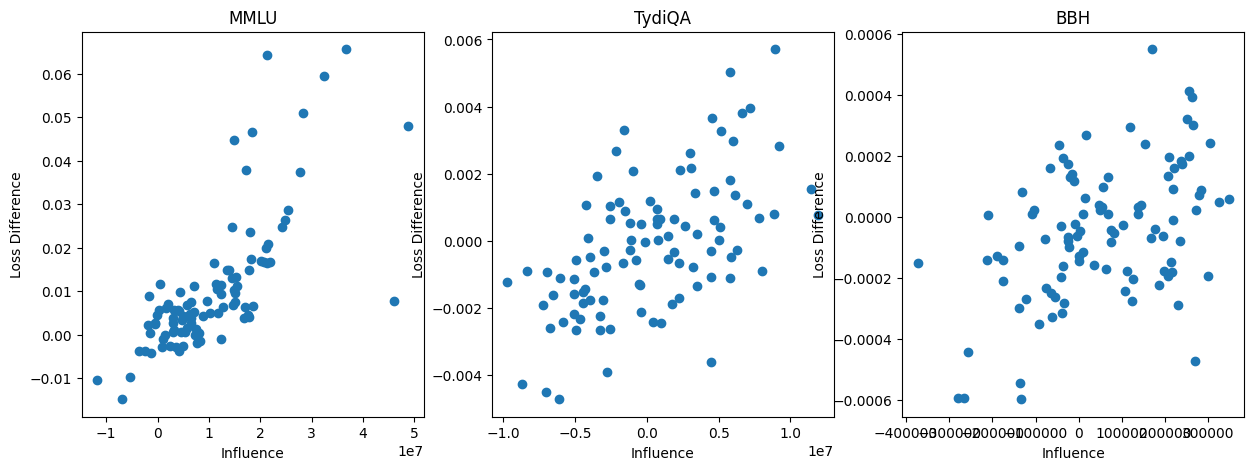

In [179]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ex in enumerate(axes):
    task = tasks[i]
    inf = infs[task]
    loss_diff = loss_diffs[task]
    ex.scatter(inf, -loss_diff)
    ex.set_title(task)
    ex.set_xlabel("Influence")
    ex.set_ylabel("Loss Difference")

In [181]:
import numpy as np
for task in tasks:
    inf = infs[task]
    loss_diff = loss_diffs[task]
    print(np.corrcoef(inf.numpy(), -loss_diff.numpy())[0, 1])

0.7392794161921709
0.5694431083382138
0.4590132411159895


In [127]:
mmlu: 0.72669043
tydiqa: 0.57507655
bbh: 0.47372344
